In [1]:
!pip install geopandas rasterio libpysal contextily mapclassify
!pip install -U tfds-nightly
!pip install focal-loss
!pip install segmentation_models_pytorch
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 26.0 MB/s 
     |████████████████████████████████| 19.3 MB 480 kB/s 
     |████████████████████████████████| 2.4 MB 29.1 MB/s 
     |████████████████████████████████| 6.3 MB 59.5 MB/s 
     |████████████████████████████████| 16.7 MB 61.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 31.7 MB/s 
     |████████████████████████████████| 98 kB 9.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.6 MB/s 
     |████████████████████████████████| 376 kB 58.0 MB/s 
     |████████████████████████████████| 58 kB 8.5 MB/s 
  Created wheel for efficient

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import glob
import numpy as np
import cv2
import fnmatch
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import segmentation_models_pytorch as smp
from sklearn.metrics import f1_score, jaccard_score

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!cp -r ./drive/MyDrive/VarunaHackathon2022/training_area/* ./

In [5]:
raster_path = "./drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021/20210101/IMG_DATA/47PQS_20210101_TCI.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [6]:
print(raster_img.shape)

(3, 2051, 2051)


In [7]:
raster_meta

{'count': 3,
 'crs': CRS.from_epsg(32647),
 'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'height': 2051,
 'nodata': 0.0,
 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0),
 'width': 2051}

In [8]:
raster_img = reshape_as_image(raster_img)

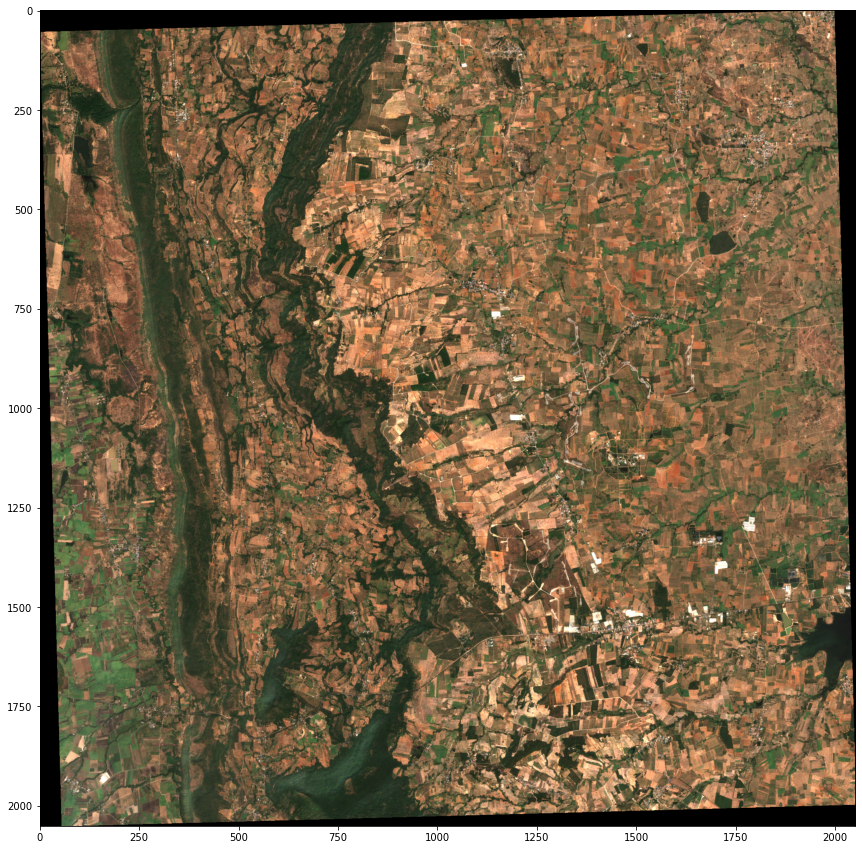

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

Class pixel count:{1: 100162, 2: 29069, 3: 84342, 4: 23309}


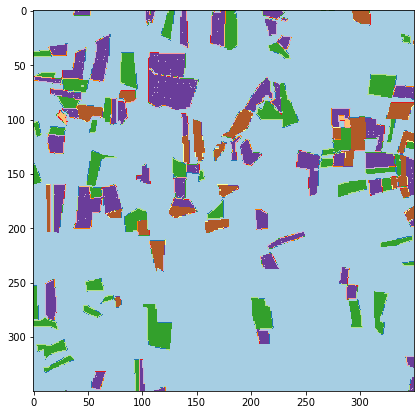

In [10]:
from rasterio.features import rasterize

img_profile = rasterio.open('./drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021/20210101/IMG_DATA/47PQS_20210101_B04.jp2').profile
label = gpd.read_file('./drive/MyDrive/VarunaHackathon2022/training_area/traindata.shp').to_crs(img_profile['crs'])

target_image = rasterize(shapes=[(row.geometry, int(row.crop_type)) for i, row in label.iterrows()], 
    out_shape=(img_profile['width'], img_profile['height']),
    transform=img_profile['transform']
    )
classes, pixel_counts = np.unique(target_image, return_counts=True)

print('Class pixel count:' + str(dict(zip(classes[1:], pixel_counts[1:]))))

plt.figure(figsize=(7,7))
plt.imshow(target_image[750:1100, 1250:1600], cmap='Paired')

In [5]:
train_df = gpd.read_file("./drive/MyDrive/VarunaHackathon2022/training_area/traindata.shp")
print(len(train_df))
train_df.head(5)

1317


,years,crop_type,geometry
0,2021,1,"POLYGON ((774604.014 1671240.055, 774606.506 1..."
1,2021,1,"POLYGON ((773367.837 1670278.438, 773389.600 1..."
2,2021,1,"POLYGON ((771648.671 1673990.960, 771707.027 1..."
3,2021,3,"POLYGON ((771306.117 1674174.738, 771426.678 1..."
4,2021,2,"POLYGON ((763750.339 1678588.825, 763879.691 1..."


In [12]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [774604.0143275484, 774606.5055553364, 774679.5517776415, 774675.7978508549, 774666.4300546482, 774604.0143275484]),
 array('d', [1671240.0548827336, 1671331.0924999372, 1671330.1703888504, 1671227.4928340595, 1671219.0801929508, 1671240.0548827336]))

In [13]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 0 files


In [6]:
all_files = os.listdir('./drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021/')

In [7]:
# outfolder = "crops"
# os.makedirs(outfolder, exist_ok=True)

datasets = [] # (1317*71, row, col, channel)
labels = []

for files in all_files:
  first_input,second_input,third_input,fourth_input = None, None, None, None
  path = glob.glob('./drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021/'+files+'/IMG_DATA/*')
  if len(fnmatch.filter(path, '*B02.jp2'))  and len(fnmatch.filter(path, '*B03.jp2')) and len(fnmatch.filter(path, '*B04.jp2')):
    band2 = rasterio.open(fnmatch.filter(path, '*B02.jp2')[0], 'r')
    band3 = rasterio.open(fnmatch.filter(path, '*B03.jp2')[0], 'r')
    band4 = rasterio.open(fnmatch.filter(path, '*B04.jp2')[0], 'r')

    first_input = np.concatenate((band2.read(), band3.read(), band4.read()))

  if len(fnmatch.filter(path, '*B05.jp2'))  and len(fnmatch.filter(path, '*B06.jp2')) and len(fnmatch.filter(path, '*B07.jp2')) and len(fnmatch.filter(path, '*B8A.jp2')):
    band5 = rasterio.open(fnmatch.filter(path, '*B05.jp2')[0], 'r').read()
    band6 = rasterio.open(fnmatch.filter(path, '*B06.jp2')[0], 'r').read()
    band7 = rasterio.open(fnmatch.filter(path, '*B07.jp2')[0], 'r').read()
    band8a = rasterio.open(fnmatch.filter(path, '*B8A.jp2')[0], 'r').read()

    second_input = np.concatenate((band5, band6, band7, band8a))
    second_input = np.resize(second_input,(4, 2051, 2051))

  if len(fnmatch.filter(path, '*B08.jp2')):
    band8 = rasterio.open(fnmatch.filter(path, '*B08.jp2')[0], 'r').read()

    third_input = band8.reshape((1, 2051, 2051))
  if len(fnmatch.filter(path, '*B11.jp2'))  and len(fnmatch.filter(path, '*B12.jp2')):
    band11 = rasterio.open(fnmatch.filter(path, '*B11.jp2')[0], 'r').read()
    band12 = rasterio.open(fnmatch.filter(path, '*B12.jp2')[0], 'r').read()

    fourth_input = np.concatenate((band11, band12))
    fourth_input = np.resize(fourth_input,(2, 2051, 2051))

  if first_input is not None and second_input is not None and third_input is not None and fourth_input is not None:
    inputs_ = np.concatenate((first_input,second_input,third_input,fourth_input),axis=0)
    
    writer = rasterio.open('temp.tiff', 'w',
            driver='Gtiff', 
            width=band2.width, 
            height=band2.height, 
            count= 10,
            crs=band2.crs, 
            transform=band2.transform, 
            dtype='uint8'
    )
    writer.write(inputs_)
    writer.close()
    inputs = rasterio.open('temp.tiff', 'r')


    failed = []

    for num, row in train_df.iterrows():
      try:
        masked_image, out_transform = rasterio.mask.mask(inputs, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_image = np.resize(img_image, (72, 72, 10))
        datasets.append(img_image)
        labels.append(int(row.crop_type))
      except Exception as e:
    #         print(e)
        failed.append(num)

    print("Rasterio failed to mask {} files".format(len(failed)))

np.save("datasets.npy",np.array(datasets))
np.save("labels.npy",np.array(labels))

Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio failed to mask 0 files
Rasterio

In [8]:
datasets = np.load('./datasets.npy')
labels = np.load('./labels.npy')

In [9]:
datasets = np.array(datasets)
datasets.shape

(93507, 72, 72, 10)

In [10]:
labels = np.array(labels)
print(labels.shape)
np.unique(labels, return_counts=True)

(93507,)


(array([1, 2, 3, 4]), array([36210, 17040, 30743,  9514]))

In [11]:
cassava = np.where(labels==1)[0][:9514]
rice = np.where(labels==2)[0][:9514]
maize = np.where(labels==3)[0][:9514]
sugarcane = np.where(labels==4)[0]
indexes = np.concatenate((cassava,rice, maize,sugarcane))

In [12]:
datasets= datasets[indexes]
labels = labels[indexes]

In [13]:
datasets = np.array(datasets)
datasets.shape

(38056, 72, 72, 10)

In [14]:
labels = np.array(labels)
labels = labels - 1
print(labels.shape)
np.unique(labels, return_counts=True)

(38056,)


(array([0, 1, 2, 3]), array([9514, 9514, 9514, 9514]))

In [15]:
X_train, X_valid, ytrain, yval = train_test_split(datasets, labels, test_size=0.2, shuffle=True, random_state= 11172)
del datasets, labels

In [16]:
print(np.unique(ytrain, return_counts=True))
print(np.unique(yval, return_counts=True))

(array([0, 1, 2, 3]), array([7677, 7557, 7612, 7598]))
(array([0, 1, 2, 3]), array([1837, 1957, 1902, 1916]))


In [17]:
class CustomData(Dataset):

  def __init__(self, data, targets, transform=None):

    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform

  def __len__(self, ):

    return len(self.data)

  def __getitem__(self, idx):

    image = self.data[idx]
    image = image / 255.
    image = np.swapaxes(image, 0, 2)

    label = self.targets[idx]

    if self.transform:
        image = self.transform(image)

    return image, label

In [18]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [19]:
class ResidualBlock(nn.Module):
  def __init__(self, in_chan, out_chan, stride= 1, downsample=None):
    super().__init__()

    self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bachNorm1 = nn.BatchNorm2d(out_chan)
    self.actReLU = nn.ReLU(inplace = True)

    self.conv2 = nn.Conv2d(out_chan, out_chan, kernel_size=3, stride= 1, padding=1, bias=False)
    self.bachNorm2 = nn.BatchNorm2d(out_chan)

    self.downsample = downsample
    self.stride = stride

    self.channelAtt = ChannelAttention(out_chan)
    self.spatialAtt = SpatialAttention()


  def forward(self, x):
    skip = x

    out = self.conv1(x)
    out = self.bachNorm1(out)
    out = self.actReLU(out)
    
    out = self.conv2(out)
    out = self.bachNorm2(out)

    out = self.channelAtt(out) * out
    out = self.spatialAtt(out) * out

    if self.downsample is not None:
      skip = self.downsample(x)

    out = out + skip
    out = self.actReLU(out)

    return out

In [20]:
class HyperResNet34(nn.Module):

  def __init__(self, BasicBlock, layers, nbClasses):
    super().__init__()

    self.inchannel = 64


    self.conv1 = nn.Conv2d(in_channels=10, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(self.inchannel)
    self.relu = nn.ReLU(inplace= True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    self.layer1 = self._resnet_layer(BasicBlock, 64, layers[0])
    self.layer2 = self._resnet_layer(BasicBlock, 128, layers[1], stride=2)
    self.layer3 = self._resnet_layer(BasicBlock, 256, layers[2], stride=2)
    self.layer4 = self._resnet_layer(BasicBlock, 512, layers[3], stride=2)

    self.conv2_3 = self.downgrade(64, 128)
    self.conv3_4 = self.downgrade(128, 256)
    self.conv4_5 = self.downgrade(256, 512)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 , nbClasses)


  def downgrade(self, inplanes, outplanes):
  
    return nn.Sequential(
        nn.Conv2d(inplanes, inplanes, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(inplanes),
        nn.ReLU(inplace= True),

        nn.Conv2d(inplanes, outplanes, kernel_size=1),
        nn.BatchNorm2d(outplanes)
      )
  
  def _resnet_layer(self, BasicBlock, outChannel, Blocks, stride=1):
    downsample = None

    if stride != 1 or self.inchannel != outChannel:

      downsample = nn.Sequential(
          nn.Conv2d(self.inchannel, outChannel, kernel_size= 1, stride= stride, bias= False),
          nn.BatchNorm2d(outChannel)
      )

    layers = []
    layers.append(BasicBlock(self.inchannel, outChannel, stride, downsample))
    self.inchannel = outChannel

    for index in range(1, Blocks):

      layers.append(BasicBlock(self.inchannel, outChannel))


    return nn.Sequential(*layers)


  def forward(self, x):

    x = self.conv1(x)           
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)   
    temp =  x
    x = self.layer2(x)
    temp = self.conv2_3(temp) + x 
    x = self.layer3(x)
    temp = self.conv3_4(temp) + x
    x = self.layer4(x) 
    temp = self.conv4_5(temp) + x

    x = self.avgpool(temp)
    x = torch.flatten(x, 1)

    x = self.fc(x)

    return x

In [21]:
def HyperCNN():
    layers=[3, 4, 6, 3]
    model = HyperResNet34(ResidualBlock, layers, 4)
    return model
    
model = HyperCNN().to(device)

In [22]:
transform = T.Compose(
   [
    T.ToTensor(),
   ]
)
train = CustomData(X_train, ytrain)
trainloader = DataLoader(train, batch_size=32, shuffle=True)

valid = CustomData(X_valid, yval)
validloader = DataLoader(valid, batch_size=32, shuffle=False)

In [23]:
epochs = 30
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), learning_rate)
criterion =  smp.losses.JaccardLoss(mode='multiclass', classes=[0,1,2,3]) #nn.CrossEntropyLoss()
filepath = 'KLPM_Model.pth'

In [24]:
def train(epoch):
  print(f'\nEpoch : {epoch}')

  model.train()

  train_loss=0
  correct=0
  total=0
  jaccards, fscore = [], []
  for img, label in tqdm(trainloader):

    img, label = img.to(device), label.to(device)

    optimizer.zero_grad()
    output = model(img.float()) 
    
    loss = criterion(output, label)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    total += label.size(0)

    _, predictions = output.max(1)
    correct += predictions.eq(label).sum().item()
    


    jaccards.append(jaccard_score(label.cpu().numpy(), predictions.cpu().numpy(), average='micro'))
    fscore.append(f1_score(label.cpu().numpy(), predictions.cpu().numpy(), average='micro'))
      
  train_loss = train_loss/len(trainloader)
  
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  jaccards_acc.append(np.mean(jaccards))
  f1_acc.append(np.mean(fscore))
  
  print('Train Loss: %.3f | Accuracy: %.3f | Jaccards: %.3f | F1 Score: %.3f'%(train_loss,accu, np.mean(jaccards), np.mean(fscore)))

In [25]:
def test(epoch):

  model.eval()

  running_loss=0
  correct=0
  total=0
  jaccards = []
  fscore = []
  with torch.no_grad():
    for img, label in validloader:

      img, label = img.to(device), label.to(device)
      
      outputs = model(img.float())

      loss= criterion(outputs, label)

      running_loss += loss.item()

      total += label.size(0)

      _, predictions = outputs.max(1)
      correct += predictions.eq(label).sum().item()

      jaccards.append(jaccard_score(label.cpu().numpy(), predictions.cpu().numpy(), average='micro'))
      fscore.append(f1_score(label.cpu().numpy(), predictions.cpu().numpy(), average='micro'))


  test_loss=running_loss/len(validloader)
  accu=100.*correct/total

  valid_losses.append(test_loss)
  valid_accu.append(accu)

  val_jaccards.append(np.mean(jaccards))
  val_f1.append(np.mean(fscore))
  print('Test Loss: %.3f | Accuracy: %.3f | Jaccards: %.3f | F1 Score: %.3f'%(test_loss, accu, np.mean(jaccards), np.mean(fscore)))

  return accu

In [26]:
train_losses, train_accu, jaccards_acc, f1_acc = [], [], [], []
valid_losses,  valid_accu, val_jaccards, val_f1 = [], [], [], []
maxAcc = 0
for epoch in range(1, epochs):
  train(epoch)
  acc = test(epoch)

  if acc > maxAcc:
    print('Save Best Model')
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    }
    torch.save(state, filepath)
    maxAcc = acc


Epoch : 1


100%|██████████| 952/952 [01:11<00:00, 13.29it/s]


Train Loss: 0.849 | Accuracy: 30.223 | Jaccards: 0.180 | F1 Score: 0.302
Test Loss: 0.838 | Accuracy: 32.094 | Jaccards: 0.194 | F1 Score: 0.321
Save Best Model

Epoch : 2


100%|██████████| 952/952 [01:11<00:00, 13.37it/s]


Train Loss: 0.827 | Accuracy: 34.230 | Jaccards: 0.210 | F1 Score: 0.342
Test Loss: 0.822 | Accuracy: 35.234 | Jaccards: 0.216 | F1 Score: 0.352
Save Best Model

Epoch : 3


100%|██████████| 952/952 [01:11<00:00, 13.37it/s]


Train Loss: 0.810 | Accuracy: 37.623 | Jaccards: 0.235 | F1 Score: 0.376
Test Loss: 0.804 | Accuracy: 38.505 | Jaccards: 0.242 | F1 Score: 0.385
Save Best Model

Epoch : 4


100%|██████████| 952/952 [01:11<00:00, 13.33it/s]


Train Loss: 0.789 | Accuracy: 40.586 | Jaccards: 0.258 | F1 Score: 0.406
Test Loss: 0.783 | Accuracy: 40.896 | Jaccards: 0.260 | F1 Score: 0.409
Save Best Model

Epoch : 5


100%|██████████| 952/952 [01:10<00:00, 13.42it/s]


Train Loss: 0.767 | Accuracy: 43.079 | Jaccards: 0.279 | F1 Score: 0.431
Test Loss: 0.760 | Accuracy: 43.471 | Jaccards: 0.281 | F1 Score: 0.435
Save Best Model

Epoch : 6


100%|██████████| 952/952 [01:11<00:00, 13.36it/s]


Train Loss: 0.739 | Accuracy: 46.137 | Jaccards: 0.305 | F1 Score: 0.461
Test Loss: 0.732 | Accuracy: 47.123 | Jaccards: 0.312 | F1 Score: 0.471
Save Best Model

Epoch : 7


100%|██████████| 952/952 [01:09<00:00, 13.70it/s]


Train Loss: 0.705 | Accuracy: 50.565 | Jaccards: 0.343 | F1 Score: 0.506
Test Loss: 0.697 | Accuracy: 52.338 | Jaccards: 0.359 | F1 Score: 0.523
Save Best Model

Epoch : 8


100%|██████████| 952/952 [01:09<00:00, 13.75it/s]


Train Loss: 0.657 | Accuracy: 56.264 | Jaccards: 0.396 | F1 Score: 0.563
Test Loss: 0.651 | Accuracy: 56.516 | Jaccards: 0.399 | F1 Score: 0.565
Save Best Model

Epoch : 9


100%|██████████| 952/952 [01:09<00:00, 13.64it/s]


Train Loss: 0.601 | Accuracy: 61.858 | Jaccards: 0.453 | F1 Score: 0.619
Test Loss: 0.598 | Accuracy: 62.191 | Jaccards: 0.456 | F1 Score: 0.622
Save Best Model

Epoch : 10


100%|██████████| 952/952 [01:09<00:00, 13.61it/s]


Train Loss: 0.534 | Accuracy: 67.885 | Jaccards: 0.520 | F1 Score: 0.679
Test Loss: 0.543 | Accuracy: 66.908 | Jaccards: 0.508 | F1 Score: 0.669
Save Best Model

Epoch : 11


100%|██████████| 952/952 [01:09<00:00, 13.77it/s]


Train Loss: 0.463 | Accuracy: 73.749 | Jaccards: 0.590 | F1 Score: 0.737
Test Loss: 0.473 | Accuracy: 72.662 | Jaccards: 0.576 | F1 Score: 0.727
Save Best Model

Epoch : 12


100%|██████████| 952/952 [01:09<00:00, 13.76it/s]


Train Loss: 0.391 | Accuracy: 79.402 | Jaccards: 0.665 | F1 Score: 0.794
Test Loss: 0.409 | Accuracy: 77.759 | Jaccards: 0.641 | F1 Score: 0.778
Save Best Model

Epoch : 13


100%|██████████| 952/952 [01:09<00:00, 13.73it/s]


Train Loss: 0.316 | Accuracy: 84.572 | Jaccards: 0.738 | F1 Score: 0.846
Test Loss: 0.402 | Accuracy: 77.877 | Jaccards: 0.644 | F1 Score: 0.779
Save Best Model

Epoch : 14


100%|██████████| 952/952 [01:09<00:00, 13.73it/s]


Train Loss: 0.244 | Accuracy: 89.078 | Jaccards: 0.808 | F1 Score: 0.891
Test Loss: 0.291 | Accuracy: 86.127 | Jaccards: 0.761 | F1 Score: 0.861
Save Best Model

Epoch : 15


100%|██████████| 952/952 [01:09<00:00, 13.74it/s]


Train Loss: 0.179 | Accuracy: 92.301 | Jaccards: 0.861 | F1 Score: 0.923
Test Loss: 0.226 | Accuracy: 89.622 | Jaccards: 0.816 | F1 Score: 0.896
Save Best Model

Epoch : 16


100%|██████████| 952/952 [01:09<00:00, 13.76it/s]


Train Loss: 0.131 | Accuracy: 94.567 | Jaccards: 0.900 | F1 Score: 0.946
Test Loss: 0.197 | Accuracy: 91.382 | Jaccards: 0.845 | F1 Score: 0.914
Save Best Model

Epoch : 17


100%|██████████| 952/952 [01:09<00:00, 13.75it/s]


Train Loss: 0.100 | Accuracy: 95.917 | Jaccards: 0.924 | F1 Score: 0.959
Test Loss: 0.152 | Accuracy: 93.458 | Jaccards: 0.880 | F1 Score: 0.935
Save Best Model

Epoch : 18


100%|██████████| 952/952 [01:09<00:00, 13.63it/s]


Train Loss: 0.078 | Accuracy: 96.834 | Jaccards: 0.940 | F1 Score: 0.968
Test Loss: 0.147 | Accuracy: 93.799 | Jaccards: 0.886 | F1 Score: 0.938
Save Best Model

Epoch : 19


100%|██████████| 952/952 [01:09<00:00, 13.61it/s]


Train Loss: 0.062 | Accuracy: 97.576 | Jaccards: 0.954 | F1 Score: 0.976
Test Loss: 0.110 | Accuracy: 95.678 | Jaccards: 0.919 | F1 Score: 0.957
Save Best Model

Epoch : 20


100%|██████████| 952/952 [01:09<00:00, 13.64it/s]


Train Loss: 0.047 | Accuracy: 98.167 | Jaccards: 0.965 | F1 Score: 0.982
Test Loss: 0.097 | Accuracy: 96.203 | Jaccards: 0.929 | F1 Score: 0.962
Save Best Model

Epoch : 21


100%|██████████| 952/952 [01:09<00:00, 13.70it/s]


Train Loss: 0.041 | Accuracy: 98.404 | Jaccards: 0.970 | F1 Score: 0.984
Test Loss: 0.089 | Accuracy: 96.466 | Jaccards: 0.934 | F1 Score: 0.965
Save Best Model

Epoch : 22


100%|██████████| 952/952 [01:09<00:00, 13.73it/s]


Train Loss: 0.037 | Accuracy: 98.499 | Jaccards: 0.971 | F1 Score: 0.985
Test Loss: 0.112 | Accuracy: 95.192 | Jaccards: 0.911 | F1 Score: 0.952

Epoch : 23


100%|██████████| 952/952 [01:09<00:00, 13.66it/s]


Train Loss: 0.034 | Accuracy: 98.607 | Jaccards: 0.973 | F1 Score: 0.986
Test Loss: 0.140 | Accuracy: 93.523 | Jaccards: 0.882 | F1 Score: 0.935

Epoch : 24


100%|██████████| 952/952 [01:09<00:00, 13.68it/s]


Train Loss: 0.030 | Accuracy: 98.742 | Jaccards: 0.976 | F1 Score: 0.987
Test Loss: 0.075 | Accuracy: 96.978 | Jaccards: 0.943 | F1 Score: 0.970
Save Best Model

Epoch : 25


100%|██████████| 952/952 [01:09<00:00, 13.67it/s]


Train Loss: 0.029 | Accuracy: 98.765 | Jaccards: 0.976 | F1 Score: 0.988
Test Loss: 0.071 | Accuracy: 97.110 | Jaccards: 0.945 | F1 Score: 0.971
Save Best Model

Epoch : 26


100%|██████████| 952/952 [01:09<00:00, 13.71it/s]


Train Loss: 0.028 | Accuracy: 98.785 | Jaccards: 0.977 | F1 Score: 0.988
Test Loss: 0.073 | Accuracy: 96.939 | Jaccards: 0.942 | F1 Score: 0.969

Epoch : 27


100%|██████████| 952/952 [01:09<00:00, 13.76it/s]


Train Loss: 0.027 | Accuracy: 98.870 | Jaccards: 0.978 | F1 Score: 0.989
Test Loss: 0.062 | Accuracy: 97.465 | Jaccards: 0.952 | F1 Score: 0.975
Save Best Model

Epoch : 28


100%|██████████| 952/952 [01:09<00:00, 13.68it/s]


Train Loss: 0.024 | Accuracy: 98.982 | Jaccards: 0.980 | F1 Score: 0.990
Test Loss: 0.062 | Accuracy: 97.412 | Jaccards: 0.951 | F1 Score: 0.974

Epoch : 29


100%|██████████| 952/952 [01:09<00:00, 13.67it/s]


Train Loss: 0.022 | Accuracy: 99.011 | Jaccards: 0.981 | F1 Score: 0.990
Test Loss: 0.060 | Accuracy: 97.583 | Jaccards: 0.954 | F1 Score: 0.976
Save Best Model


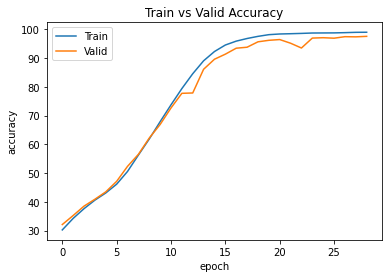

In [27]:
plt.plot(train_accu,'-')
plt.plot(valid_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

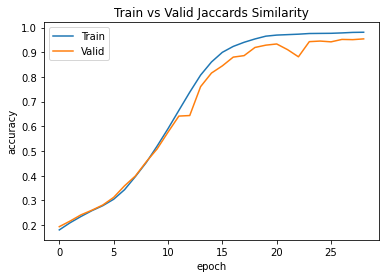

In [28]:
plt.plot(jaccards_acc,'-')
plt.plot(val_jaccards,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Jaccards Similarity')

plt.show()

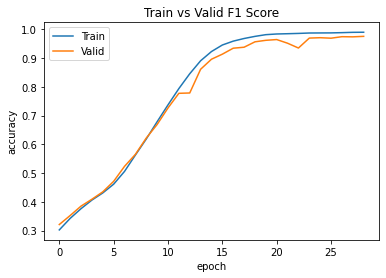

In [29]:
plt.plot(f1_acc,'-')
plt.plot(val_f1,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid F1 Score')

plt.show()

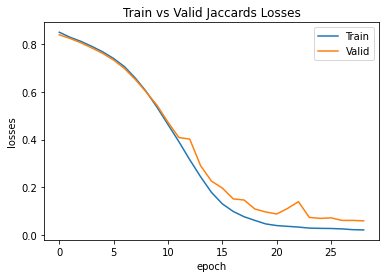

In [30]:
plt.plot(train_losses,'-')
plt.plot(valid_losses,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Jaccards Losses')

plt.show()

#**TESTING CODES**

In [31]:
class CustomTestData(Dataset):

  def __init__(self, data, transform=None):

    super().__init__()

    self.data = data
    self.transform = transform

  def __len__(self, ):

    return len(self.data)

  def __getitem__(self, idx):

    image = self.data[idx]
    image = image / 255.
    image = np.swapaxes(image, 0, 2)

    if self.transform:
        image = self.transform(image)

    return image

In [32]:
!cp -r ./drive/MyDrive/VarunaHackathon2022/testing_area/* ./

In [33]:
test_df = gpd.read_file("./drive/MyDrive/VarunaHackathon2022/testing_area/testdata.shp")
print(len(test_df))
test_df.head(5)

565


,years,geometry
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1..."
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1..."
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1..."
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1..."
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1..."


In [34]:
# testlabels = []
df = pd.DataFrame()
Testdatasets = [] # (1317*71, row, col, channel)

for files in ['20210121']: #'20201227','20210312',

  
  first_input,second_input,third_input,fourth_input = None, None, None, None

  path = glob.glob('./drive/MyDrive/VarunaHackathon2022/sentinel-2-image/2021/'+files+'/IMG_DATA/*')
  if len(fnmatch.filter(path, '*B02.jp2'))  and len(fnmatch.filter(path, '*B03.jp2')) and len(fnmatch.filter(path, '*B04.jp2')):
    band2 = rasterio.open(fnmatch.filter(path, '*B02.jp2')[0], 'r')
    band3 = rasterio.open(fnmatch.filter(path, '*B03.jp2')[0], 'r')
    band4 = rasterio.open(fnmatch.filter(path, '*B04.jp2')[0], 'r')

    first_input = np.concatenate((band2.read(), band3.read(), band4.read()))

  if len(fnmatch.filter(path, '*B05.jp2'))  and len(fnmatch.filter(path, '*B06.jp2')) and len(fnmatch.filter(path, '*B07.jp2')) and len(fnmatch.filter(path, '*B8A.jp2')):
    band5 = rasterio.open(fnmatch.filter(path, '*B05.jp2')[0], 'r').read()
    band6 = rasterio.open(fnmatch.filter(path, '*B06.jp2')[0], 'r').read()
    band7 = rasterio.open(fnmatch.filter(path, '*B07.jp2')[0], 'r').read()
    band8a = rasterio.open(fnmatch.filter(path, '*B8A.jp2')[0], 'r').read()

    second_input = np.concatenate((band5, band6, band7, band8a))
    second_input = np.resize(second_input,(4, 2051, 2051))

  if len(fnmatch.filter(path, '*B08.jp2')):
    band8 = rasterio.open(fnmatch.filter(path, '*B08.jp2')[0], 'r').read()

    third_input = band8.reshape((1, 2051, 2051))
  if len(fnmatch.filter(path, '*B11.jp2'))  and len(fnmatch.filter(path, '*B12.jp2')):
    band11 = rasterio.open(fnmatch.filter(path, '*B11.jp2')[0], 'r').read()
    band12 = rasterio.open(fnmatch.filter(path, '*B12.jp2')[0], 'r').read()

    fourth_input = np.concatenate((band11, band12))
    fourth_input = np.resize(fourth_input,(2, 2051, 2051))

  if first_input is not None and second_input is not None and third_input is not None and fourth_input is not None:
    inputs_ = np.concatenate((first_input,second_input,third_input,fourth_input),axis=0)
    
    writer = rasterio.open('test.tiff', 'w',
            driver='Gtiff', 
            width=band2.width, 
            height=band2.height, 
            count= 10,
            crs=band2.crs, 
            transform=band2.transform, 
            dtype='uint8'
    )
    writer.write(inputs_)
    writer.close()
    inputs = rasterio.open('test.tiff', 'r')


    failed = []

    for num, row in test_df.iterrows():
      try:
        masked_image, out_transform = rasterio.mask.mask(inputs, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_image = np.resize(img_image, (72, 72, 10))
        Testdatasets.append(img_image)
        # testlabels.append(int(row.crop_type))
      except Exception as e:
        #print(e)
        failed.append(num)

    print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 0 files


In [35]:
Testdatasets = np.array(Testdatasets)
print(Testdatasets.shape)
test = CustomTestData(Testdatasets)
testloader = DataLoader(test, batch_size=1, shuffle=False)

(565, 72, 72, 10)


In [36]:
model.eval()
predictionsValues = []
with torch.no_grad():
  for img in testloader:

    img = img.to(device)
      
    outputs = model(img.float())
    # print(outputs.max(1))
    _, predictions = outputs.max(1)

    predictionsValues.append(predictions.item())

In [42]:
predictValues = np.array(predictionsValues) + 1
np.unique(predictValues, return_counts=True)

(array([1, 2, 3, 4]), array([220, 109, 204,  32]))

In [39]:
df = pd.DataFrame({
    '20210121': predictValues
})
df.groupby('20210121').size()

20210121
1    220
2    109
3    204
4     32
dtype: int64

In [40]:
df

,20210121
0,3
1,3
2,1
3,2
4,3
...,...
560,3
561,3
562,1
563,2


In [43]:
df.to_csv('./KLPM_Scores.csv')